# Imports

In [1]:
from spmf import Spmf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt

pd.options.display.max_colwidth = 500000

Reading in the original data where the package names have been encoded, and observations are sorted by user and then start time.

In [2]:
data = pd.read_csv('sorted_coded_data.csv')

#  Initial sleeptime distribution

In this section we take an initial look at the sleep time distribution.

I start by calculating the sleep time for each app. Here it corresponds to the time from when the user closed the previous opened app, to he/she opened the current app.

In [3]:
user_groups=data.groupby('user_id')

In [4]:
data['sleep_time']=user_groups['end_time'].shift(1,fill_value=0.0)

In [8]:
data[data.start_time<data.sleep_time]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time
11,bg.abv.andro.emailapp,0,3689,3699,10,2340,3926.0
20,com.facebook.katana,0,28836,29777,941,19968,28906.0
59,com.google.android.apps.translate,0,53793,53803,10,23926,54003.0
110,com.sonyericsson.video,0,173946,174206,260,45286,173976.0
111,com.sonyericsson.album,0,174036,174046,10,45260,174206.0
...,...,...,...,...,...,...,...
254450355,com.sonyericsson.music,9999,29133717,29133737,20,45284,29134004.0
254450372,com.google.android.googlequicksearchbox,9999,29156883,29156933,50,23949,29156994.0
254450378,com.sonyericsson.album,9999,29158879,29158889,10,45260,29158899.0
254450387,com.whatsapp,9999,29162905,29163029,124,53003,29162955.0


As we can see here there is quit a few apps that are being used at least partially at the same time as other apps. This is indicated by the fact that the app is opened before the previous one is closed. For now we will consider this as zero sleep instances, but for further analysis it is worth considering if these should be considered as item sets, or sequences.

In [5]:
print("min sleep time: ",data.sleep_time.min())
print("min sleep time: ",data.sleep_time.max())

min sleep time:  0.0
min sleep time:  78889680.0


In [6]:
data['sleep_time']=data['start_time']-data['sleep_time']

Here the probplem of overlapping app usage results in negative sleep times. For this part of the analysis they will be considered as zero.

In [9]:
print("min sleep time: ",data.sleep_time.min())
print("min sleep time: ",data.sleep_time.max())

min sleep time:  -59221.0
min sleep time:  7728262.0


In [7]:
data['sleep_time_modified']=data.sleep_time.copy()

In [8]:
data.sleep_time_modified[data['sleep_time']<0]=0

<ipython-input-8-c9d15e498dfa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.sleep_time_modified[data['sleep_time']<0]=0


In [9]:
print("procent of apps used at the same time as another app :",data[data.sleep_time<0].shape[0]/data.shape[0]*100)

procent of apps used at the same time as another app : 7.11492590882793


In [8]:
data[data.sleep_time<0]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified
11,bg.abv.andro.emailapp,0,3689,3699,10,2340,-237.0,0.0
20,com.facebook.katana,0,28836,29777,941,19968,-70.0,0.0
59,com.google.android.apps.translate,0,53793,53803,10,23926,-210.0,0.0
110,com.sonyericsson.video,0,173946,174206,260,45286,-30.0,0.0
111,com.sonyericsson.album,0,174036,174046,10,45260,-170.0,0.0
...,...,...,...,...,...,...,...,...
254450355,com.sonyericsson.music,9999,29133717,29133737,20,45284,-287.0,0.0
254450372,com.google.android.googlequicksearchbox,9999,29156883,29156933,50,23949,-111.0,0.0
254450378,com.sonyericsson.album,9999,29158879,29158889,10,45260,-20.0,0.0
254450387,com.whatsapp,9999,29162905,29163029,124,53003,-50.0,0.0


In [10]:
data.sleep_time_modified.quantile(q=0.90)/60

36.6

In [11]:
data.sleep_time_modified.quantile(q=0.99)/60/60

7.878611111111111

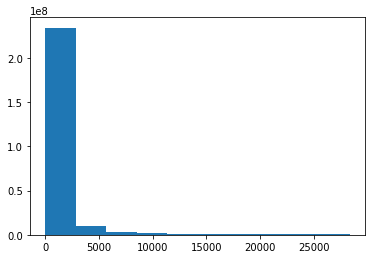

In [30]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=data.sleep_time_modified.quantile(q=0.99)])
plt.show()

Again we see that most of the observations have a very low sleep time so we again constrict the interval of intrest. 

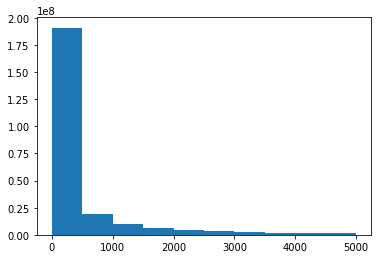

In [32]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=5000])
plt.show()

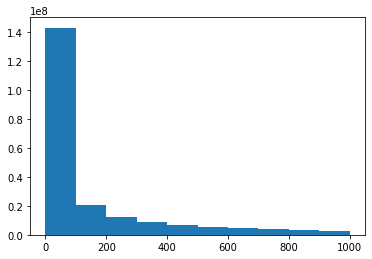

In [18]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=1000])
plt.show()

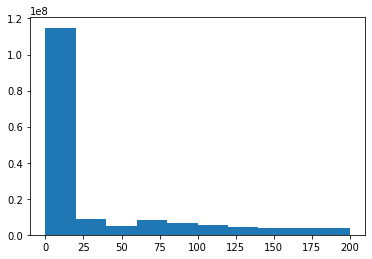

In [19]:
plt.hist(data.sleep_time_modified[data.sleep_time_modified<=200])
plt.show()

# Opening the same data twice
Here we investigate the possiblity of opening the same data right after each other. As we are intrested in the patterns of usage it is not neccessarily of much intrest that you close an app and immediatly open it again to continue the same activity.

We start by the number of times the app which is opend is the same as the last one opened.

In [12]:
data["previous_app_code"]=user_groups.app_code.shift(1)

In [13]:
data.app_code[data.app_code==data.previous_app_code].count()

55448447

In [146]:
print("Procent of all apps which are opened directly after the same app: ",data.app_code[data.app_code==data.previous_app_code].count()/data.shape[0]*100)

Procent of all apps which are opened directly after the same app:  21.791454132467504


we now take all look at the sleeping times for these obervations

In [147]:
print("max sleep time: ",data.sleep_time[data.app_code==data.previous_app_code].max())
print("min sleep time: ",data.sleep_time[data.app_code==data.previous_app_code].min())

max sleep time:  6067204.0
min sleep time:  -23445.0


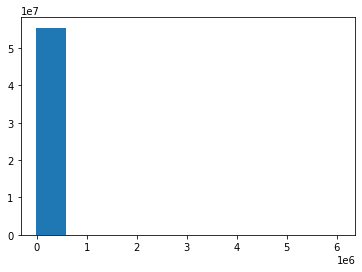

In [38]:
plt.hist(data.sleep_time[data.app_code==data.previous_app_code])
plt.show()

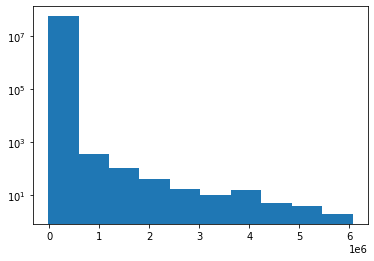

In [39]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code) ])
plt.yscale('log')
plt.show()

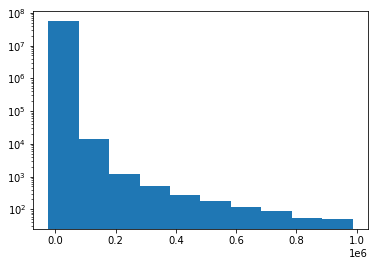

In [40]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<1000000)])
plt.yscale('log')
plt.show()

However we are esspecially interested in the ones used very close to each other.

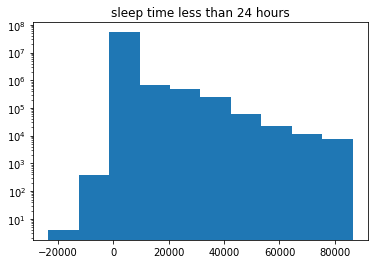

In [41]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<60*60*24)])
plt.yscale('log')
plt.title("sleep time less than 24 hours")
plt.show()

In [148]:
print("number of times the same app is opened while the app is in use: ",data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<0)].count())
print("number of times the same app is opened right after (sleep time 0): ",data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time==0)].count())

number of times the same app is opened while the app is in use:  4821
number of times the same app is opened right after (sleep time 0):  409933


We see that a small number is used at the same time. For our purpose it is clear that these should be combined. Also we see that approcimately 400000 are opened imediatly after with no sleep time in between. For these it is also clear that they can be combined. Therefor we now filter out the observations which fall into any of theses two catagories, to focus on the observations where there in reality is a sleep time.

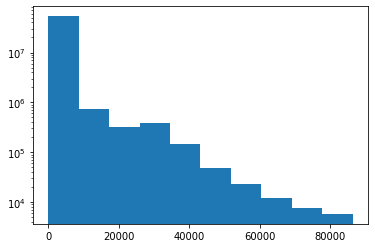

In [43]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<60*60*24)&(data.sleep_time>0)])
plt.yscale('log')
plt.show()

In [44]:
data.sleep_time[(data.app_code==data.previous_app_code)].mean()

1553.9468436329696

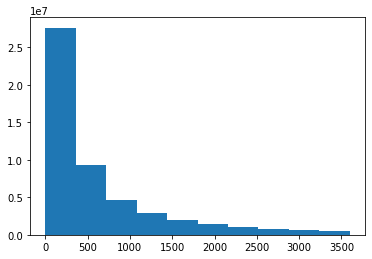

In [45]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<60*60)&(data.sleep_time>0)])
plt.show()

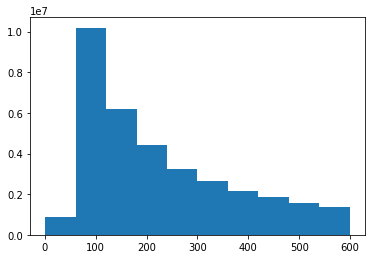

In [46]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<10*60)&(data.sleep_time>0)])
plt.show()

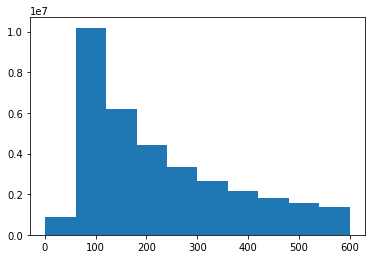

In [49]:
plt.hist(data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<=10*60)&(data.sleep_time>0)])
plt.show()

In [149]:
data.sleep_time[(data.app_code==data.previous_app_code)& (data.sleep_time<=10*60)&(data.sleep_time>0)].count()/data.sleep_time[(data.app_code==data.previous_app_code)&(data.sleep_time>0)].count()

0.6278039527530889

In [15]:
print("The median of sleep times for apps opened right after the previous app:",data.sleep_time[(data.app_code==data.previous_app_code)&(data.sleep_time>0)].median()/60)

The median of sleep times for apps opened right after the previous app: 5.983333333333333


In [15]:
print("The median of sleep times for apps opened right after the previous app:",data.sleep_time[(data.app_code==data.previous_app_code)&(data.sleep_time>0)&(data.sleep_time<=60*8)].median()/60)

The median of sleep times for apps opened right after the previous app: 2.7333333333333334


In [17]:
print("The 90-quantile of sleep times for apps opened right after the previous app:",data.sleep_time[(data.app_code==data.previous_app_code)&(data.sleep_time>0)&(data.sleep_time<=60*8)].quantile(q=0.9)/60)

The 90-quantile of sleep times for apps opened right after the previous app: 6.366666666666666


In [17]:
print("The 60-quantile of sleep times for apps opened right after the previous app:",data.sleep_time[(data.app_code==data.previous_app_code)&(data.sleep_time>0)].quantile(q=0.6)/60)

The 60-quantile of sleep times for apps opened right after the previous app: 8.9


We see that by setting the limit to 10 mins we get more than 60 procent of the observations.
Now we combine the observations where the same app is used again after a maximum of 10min sleep time.

In [50]:
data[(data.app_code==data.previous_app_code)& (data.sleep_time<=10*60)&(data.sleep_time>0)]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
7,com.whatsapp,0,2183,2221,38,53003,395.0,395.0,53003.0
14,com.whatsapp,0,4712,4742,30,53003,556.0,556.0,53003.0
26,com.android.chrome,0,33229,33239,10,7649,460.0,460.0,7649.0
28,com.sonyericsson.album,0,33552,33562,10,45260,217.0,217.0,45260.0
46,com.sonyericsson.android.socialphonebook,0,48785,48795,10,45261,491.0,491.0,45261.0
...,...,...,...,...,...,...,...,...,...
254450388,com.whatsapp,9999,29163246,29163262,16,53003,217.0,217.0,53003.0
254450389,com.whatsapp,9999,29163490,29163500,10,53003,228.0,228.0,53003.0
254450399,com.facebook.katana,9999,29167795,29167859,64,19968,280.0,280.0,19968.0
254450405,com.snapchat.android,9999,29201485,29201495,10,44880,256.0,256.0,44880.0


## Combine observations

In [18]:
data2=data.copy()

For all app usages that should be merged together, the indexes of those with the highest end time.\
This mean that we are only interested in obervertions that need to be merged so the first step is to filter the data according to this criteria.

In [19]:
data2=data2[(data2.previous_app_code==data2.app_code) | (data2.app_code==data2.app_code.shift(-1))]

We now identify which belong to the same event. This is done in order to accomendate situation where the same app is used more than twice in a row. Here the critia is selected to be 10 min.\
Insperation for this part of the solution was found here: https://stackoverflow.com/questions/38885770/weather-events-grouped-based-on-time-differences-in-pandas (visited 24.9.2021)

In [20]:
data2['new_event'] = data2.groupby(['user_id','app_code']).sleep_time.apply(lambda s: s>60*10)

In [21]:
data2.loc[data2[data2.app_code!=data2.previous_app_code].index,'new_event'] = True

In [22]:
data2['event'] = data2.groupby(['user_id','app_code']).new_event.cumsum().astype('int')

In [155]:
data2[data2.package_name=="com.whatsapp"].iloc[0:30,:]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,new_event,event
6,com.whatsapp,0,1712,1788,76,53003,0.0,0.0,23967.0,True,1
7,com.whatsapp,0,2183,2221,38,53003,395.0,395.0,53003.0,False,1
8,com.whatsapp,0,3449,3579,130,53003,1228.0,1228.0,53003.0,True,2
13,com.whatsapp,0,4076,4156,80,53003,0.0,0.0,7649.0,True,3
14,com.whatsapp,0,4712,4742,30,53003,556.0,556.0,53003.0,False,3
120,com.whatsapp,0,175736,175916,180,53003,0.0,0.0,7649.0,True,4
121,com.whatsapp,0,176086,176166,80,53003,170.0,170.0,53003.0,False,4
133,com.whatsapp,0,177236,177267,31,53003,-141.0,0.0,7649.0,True,5
134,com.whatsapp,0,177377,177567,190,53003,110.0,110.0,53003.0,False,5
136,com.whatsapp,0,178561,178581,20,53003,1044.0,1044.0,19968.0,True,6


We are now ready to identify the indexes of the highest end time for each event.\
Insperation for this part of the solution was found here: https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-value-in-groups-using-groupby (visited 24.9.2021)

In [23]:
data2_grouped = data2.groupby(['user_id', 'app_code','event']).agg({'end_time':'max'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'end_time':'event_end_time'})

data3 = pd.merge(data2, data2_grouped, how='left', on=['user_id', 'app_code','event'])

data3 = data3[data3['end_time'] == data3['event_end_time']]

#because in the same event more apps can be closed at once.
data3=data3.drop_duplicates(subset=['user_id', 'app_code','event'], keep='last')

We now have the index of the end times for the ones that need to be combined,

In [24]:
max_index=data2.iloc[data3.index].index

We now need to find the index of the lowest start time within each of the events, that needs to be combined.

In [25]:
data2_grouped = data2.groupby(['user_id', 'app_code','event']).agg({'start_time':'min'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'start_time':'event_start_time'})

data3 = pd.merge(data2, data2_grouped, how='left', on=['user_id', 'app_code','event'])

data3 = data3[data3['start_time'] == data3['event_start_time']]

#because in the same event more apps can be opened at once.
data3=data3.drop_duplicates(subset=['user_id', 'app_code','event'], keep='last')

In [26]:
min_index=data2.iloc[data3.index].index

As a sanity check we count the number of combined events, the number of min indices and the number of max indices, as they all three should be the same.

In [27]:
print("number of combined events: ",data2.groupby(['user_id','app_code']).agg({"event": "nunique"}).event.sum())
print("number of found min indices: ",len(min_index))
print("number of found max indices: ",len(max_index))

number of combined events:  56474120
number of found min indices:  56474120
number of found max indices:  56474120


The observations can now be updated.

In [28]:
data3=data.copy()

In [29]:
data3.loc[min_index,"end_time"]=data3.loc[max_index].set_index(min_index).end_time

In [30]:
data3=data3.drop(set(data2.index)-set(min_index))

In [31]:
data3

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
0,com.facebook.katana,0,0,441,441,19968,0.0,0.0,NaN
1,com.android.chrome,0,441,1012,571,7649,0.0,0.0,19968.0
2,com.google.android.apps.photos,0,1012,1032,20,23916,0.0,0.0,7649.0
3,com.facebook.katana,0,1042,1502,460,19968,10.0,10.0,23916.0
4,com.whatsapp,0,1512,1572,60,53003,10.0,10.0,19968.0
...,...,...,...,...,...,...,...,...,...
254450417,com.google.android.googlequicksearchbox,9999,29207214,29207244,30,23949,185.0,185.0,19968.0
254450418,com.android.chrome,9999,29207244,29207284,40,7649,0.0,0.0,23949.0
254450419,com.google.android.apps.docs,9999,29207284,29207294,10,23875,0.0,0.0,7649.0
254450420,com.microsoft.office.outlook,9999,29213184,29213213,29,33357,5890.0,5890.0,23875.0


In [32]:
len(data.index)-(len(data2.index)-len(min_index))==len(data3.index)

True

Then the time spend is updated, as well as the sleep time is updated and the previous app code

In [33]:
data3['time_spend']=data3['end_time']-data3['start_time']

In [34]:
user_groups=data3.groupby('user_id')

In [35]:
data3['sleep_time']=data3['end_time'].shift(1,fill_value=0.0)
data3['sleep_time']=data3.start_time-data3['sleep_time']

In [36]:
data3[data3.sleep_time<0].sleep_time_modified=0

/home/s164574/.conda/envs/myenv/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [37]:
data3['previous_app_code']=data3.app_code.shift(1)

now the index is reset

In [38]:
data3=data3.reset_index(drop=True)

In [173]:
data3.to_csv("sorted_coded_data_with_merged_events_10_min.csv",index=False)

We now look at the updated numbers for the same app used right after each.

In [175]:
print("Number of same number of apps after the same app: ",data3.app_code[data3.app_code==data3.previous_app_code].count())
print("Procent of apps which are the same as the previous: ",data3.app_code[data3.app_code==data3.previous_app_code].count()/len(data3.app_code)*100)

Number of same number of apps after the same app:  20483819
Procent of apps which are the same as the previous:  9.332661087851086


We see that now less a little over 9% of the the observations represent the same apps.

An alternative would be to use the 90-quantlie to select where we choose to split, because the 10 min still seem a little random.

# Use time of apps.
Part of the intrest in use times is that if we are intrested in understanding how we use apps, it can cloud the overall image to look at something which might be for instance is opened by mistake, here can the use times for instance be an indication if for instance an app is only opened for a second, then the user will not actualy interact with the app.

In [43]:
data=pd.read_csv("sorted_coded_data_with_merged_events_10_min.csv")

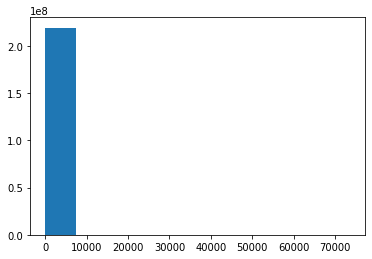

In [47]:
plt.hist(data.time_spend)
plt.show()

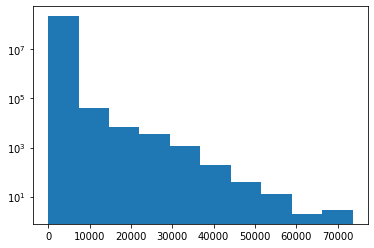

In [48]:
plt.hist(data.time_spend)
plt.yscale('log')
plt.show()

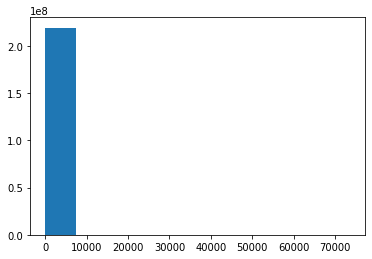

In [49]:
bins=plt.hist(data.time_spend)

In [50]:
bins

(array([2.19431821e+08, 4.15580000e+04, 7.01400000e+03, 3.50600000e+03,
        1.15500000e+03, 1.87000000e+02, 3.90000000e+01, 1.30000000e+01,
        2.00000000e+00, 3.00000000e+00]),
 array([1.00000e+00, 7.36170e+03, 1.47224e+04, 2.20831e+04, 2.94438e+04,
        3.68045e+04, 4.41652e+04, 5.15259e+04, 5.88866e+04, 6.62473e+04,
        7.36080e+04]),
 <BarContainer object of 10 artists>)

In [71]:
print("The 90-quantile of spend time: ",data.time_spend.quantile(q=0.90)/60," min.")

The 90-quantile of spend time:  8.85  min.


In [72]:
print("Shortest time spend in an app: ",data.time_spend.min()," sec.")
print("Longest time spend in an app: ",data.time_spend.max()/60/60, " hours.")


Shortest time spend in an app:  1  sec.
Longest time spend in an app:  20.446666666666665  hours.


We see that the lowest number of use times is 1 second, and that most of the use times are in the interval between 1 sec. to 7361.70 sec (which coresponds to approximately 2 hours and 5 min.). Below we also see that 90 procent of the observations are below 8.85 min, indicating that while the there is a large rande in the times spend in apps, the fast majority is only used for short period of times. This also mean that we need to look closer at the lower range to see the effect of evaluating potential apps used by mistake/no interaction.

In [75]:
print("procent of observations where a app is used a minute or less: ", data[data.time_spend<=60].app_code.count()/data.shape[0]*100)

procent of observations where a app is used a minute or less:  51.546304026249636


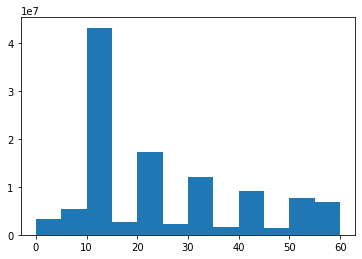

In [77]:
plt.hist(data[data.time_spend<=60].time_spend,bins=[0, 5, 10, 15, 20, 25, 30,35,40,45,50,55,60])
plt.show()

It is clear than most of the app uses for a minute or less, is used for 10 to 15 seconds. Based on this it does not make a lot of sense to exclude observation within this interval or higher. As it indicates a pretty common use pattern.

In [78]:
print("procent of observations where a app is used less than 10 seconds: ", data[data.time_spend<10].app_code.count()/data.shape[0]*100)

procent of observations where a app is used less than 10 seconds:  3.9630563319097574


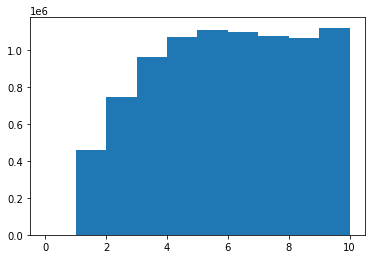

In [79]:
plt.hist(data[data.time_spend<10].time_spend,bins=[0, 1, 2, 3, 4, 5, 6,7,8,9,10])
plt.show()

maybe the ones that are opend for only one second or one to two secons are worth removing but it is kinda hard to tell.

In [84]:
print("number of different apps used for less than 2 seconds :",data[data.time_spend<2].app_code.nunique())
print("number of different apps used for less than 3 seconds :",data[data.time_spend<3].app_code.nunique())

numer of different apps used for less than 2 seconds : 5910
numer of different apps used for less than 3 seconds : 8545


Checking if certian apps dominate

In [91]:
data[data.time_spend<2].groupby('app_code').user_id.count().max()/data[data.time_spend<2].shape[0]*100

15.264125885734755

In [93]:
data[data.time_spend<3].groupby('app_code').user_id.count().max()/data[data.time_spend<3].shape[0]*100

13.409546707470682

In [94]:
data[data.time_spend<2].groupby('app_code').user_id.count().max()

69881

In [95]:
data[data.time_spend<2].app_code.value_counts()[:10].index.tolist()

[23949, 53003, 19968, 45264, 19973, 7655, 23906, 7649, 45329, 23947]

In [98]:
data[data.app_code==23949]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
58,com.google.android.googlequicksearchbox,0,67574,67584,10,23949,-6340.0,6340.0,7649.0
963,com.google.android.googlequicksearchbox,0,1611141,1611151,10,23949,978.0,0.0,23967.0
1075,com.google.android.googlequicksearchbox,0,1839621,1839631,10,23949,40.0,0.0,19968.0
1644,com.google.android.googlequicksearchbox,0,2794866,2794876,10,23949,-31741.0,31741.0,44582.0
4739,com.google.android.googlequicksearchbox,0,10173976,10174016,40,23949,-271.0,271.0,45264.0
...,...,...,...,...,...,...,...,...,...
219485231,com.google.android.googlequicksearchbox,9999,29129783,29129853,70,23949,0.0,0.0,45264.0
219485250,com.google.android.googlequicksearchbox,9999,29146727,29146737,10,23949,-1542.0,1542.0,53003.0
219485253,com.google.android.googlequicksearchbox,9999,29156883,29156933,50,23949,111.0,0.0,44880.0
219485293,com.google.android.googlequicksearchbox,9999,29207214,29207244,30,23949,-185.0,185.0,19968.0


In [109]:
data[data.time_spend<2].package_name.value_counts().sort_values(ascending=False)[:10]/data[data.time_spend<2].shape[0]*100

com.google.android.googlequicksearchbox    15.264126
com.whatsapp                                8.186985
com.facebook.katana                         6.310451
com.sonyericsson.conversations              5.560143
com.facebook.orca                           4.811582
com.android.phone                           3.990066
com.google.android.apps.maps                3.750448
com.android.chrome                          3.641451
com.sonymobile.email                        3.071566
com.google.android.gm                       3.055184
Name: package_name, dtype: float64

In [112]:
data[data.time_spend<=10].package_name.value_counts().sort_values(ascending=False)[:10]/data[data.time_spend<=10].shape[0]*100

com.whatsapp                                9.648410
com.google.android.googlequicksearchbox     9.252028
com.facebook.katana                         7.470179
com.facebook.orca                           7.001800
com.sonyericsson.conversations              6.608131
com.android.chrome                          4.894364
com.google.android.gm                       4.005481
com.sonymobile.email                        3.959347
com.sonyericsson.android.socialphonebook    3.369362
com.instagram.android                       3.017417
Name: package_name, dtype: float64

# Updated sleep distribution
In this section we take an updated look at the sleep distribution after the apps were merged.

In [44]:
print("Procent of apps which are opened before the previous one is closed :",data[data.sleep_time<0].shape[0]/data.shape[0]*100)

Procent of apps which are opened before the previous one is closed : 8.251323512338399


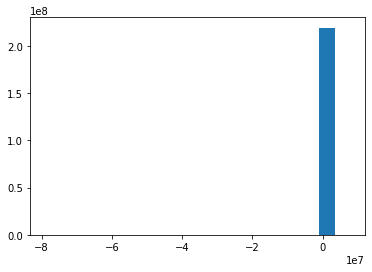

In [11]:
plt.hist(data.sleep_time,bins=20)
plt.show()

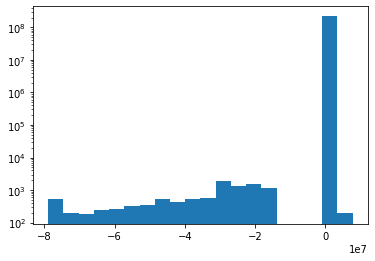

In [12]:
plt.hist(data.sleep_time,bins=20)
plt.yscale('log')
plt.show()

We see that most of the data is closer to a positive sleep time.

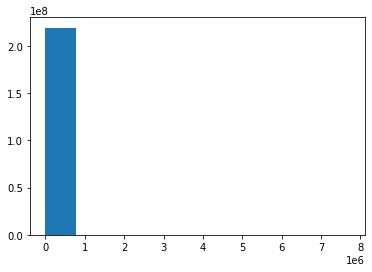

In [18]:
plt.hist(data.sleep_time_modified)
plt.show()

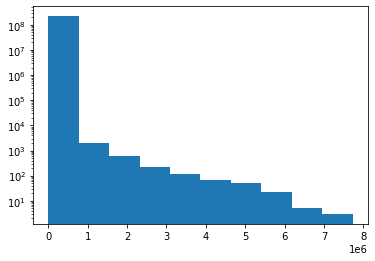

In [14]:
plt.hist(data.sleep_time_modified,bins)
plt.yscale('log')
plt.show()

43.833333333333336


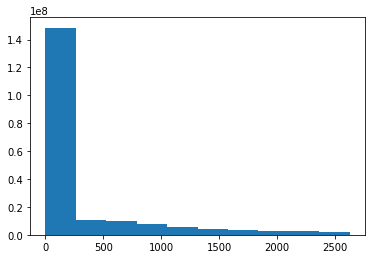

In [16]:
print(data.sleep_time_modified.quantile(0.9)/60)
plt.hist(data[data.sleep_time_modified<=data.sleep_time_modified.quantile(0.9)].sleep_time_modified)
plt.show()

43.833333333333336


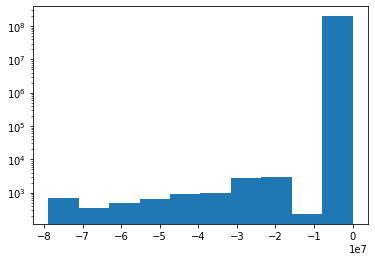

In [21]:
print(data.sleep_time.quantile(0.9)/60)
plt.hist(data[data.sleep_time<=data.sleep_time.quantile(0.9)].sleep_time)
plt.yscale('log')
plt.show()

Again we notice that while the majority of the data is in the higher end a noticable amount is negative, indicating overlap in use time. With the goal of figuring out where to thresshold the sleep times to devide the data into sessions, we are not intrested in sleep times, as we already know that these indicate that two apps will belong to the same session.

(array([2.0137177e+08, 1.9820000e+03, 6.2100000e+02, 2.2500000e+02,
        1.1300000e+02, 6.5000000e+01, 5.0000000e+01, 2.2000000e+01,
        5.0000000e+00, 3.0000000e+00]),
 array([      0. ,  772826.2, 1545652.4, 2318478.6, 3091304.8, 3864131. ,
        4636957.2, 5409783.4, 6182609.6, 6955435.8, 7728262. ]),
 <BarContainer object of 10 artists>)

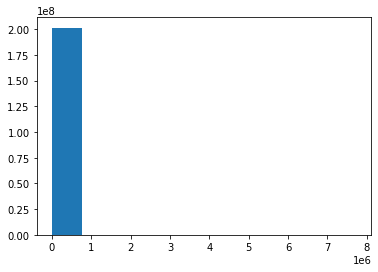

In [22]:
plt.hist(data[data.sleep_time>=0].sleep_time)

In [202]:
772826.2/60/60/24

8.944747685185185

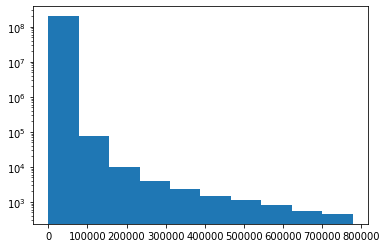

In [23]:
bins=plt.hist(data[(data.sleep_time>=0)&(data.sleep_time<=9*24*60*60)].sleep_time)
plt.yscale('log')
plt.show()

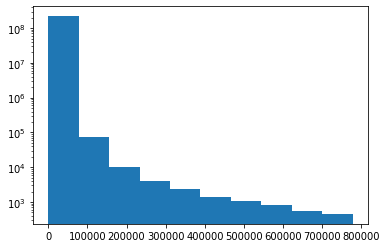

In [25]:
bins=plt.hist(data[(data.sleep_time<=9*24*60*60)].sleep_time_modified)
plt.yscale('log')
plt.show()

In [26]:
bins

(array([2.19386426e+08, 7.50030000e+04, 1.01240000e+04, 3.98500000e+03,
        2.33900000e+03, 1.43900000e+03, 1.10400000e+03, 8.02000000e+02,
        5.69000000e+02, 4.55000000e+02]),
 array([     0. ,  77750.6, 155501.2, 233251.8, 311002.4, 388753. ,
        466503.6, 544254.2, 622004.8, 699755.4, 777506. ]),
 <BarContainer object of 10 artists>)

In [208]:
77750.6/60/60

21.59738888888889

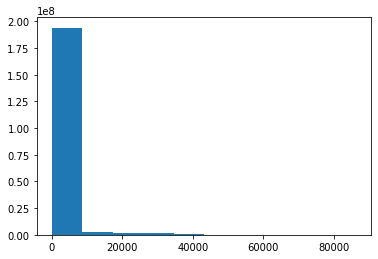

In [209]:
bins=plt.hist(data[(data.sleep_time>=0)&(data.sleep_time<=24*60*60)].sleep_time)
plt.show()

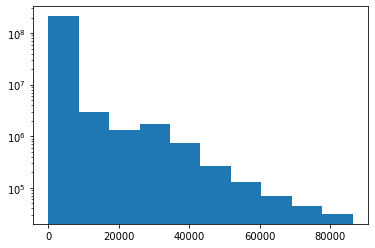

In [29]:
bins=plt.hist(data[(data.sleep_time<=24*60*60)].sleep_time_modified)
plt.yscale('log')
plt.show()

In [30]:
bins

(array([2.12095072e+08, 2.99983600e+06, 1.32621600e+06, 1.73497600e+06,
        7.24568000e+05, 2.66250000e+05, 1.26771000e+05, 6.90320000e+04,
        4.37350000e+04, 3.11760000e+04]),
 array([    0.,  8640., 17280., 25920., 34560., 43200., 51840., 60480.,
        69120., 77760., 86400.]),
 <BarContainer object of 10 artists>)

In [220]:
8640/60/60

2.4

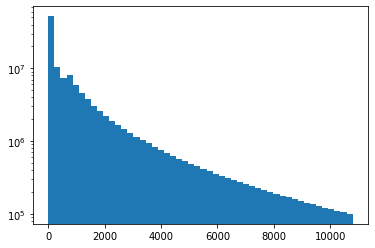

In [17]:
bins=plt.hist(data[(data.sleep_time>0)&(data.sleep_time<=3*60*60)].sleep_time,bins=50)
plt.yscale('log')
plt.show()

In [20]:
data[(data.sleep_time>0)&(data.sleep_time<=6*60*60)].sleep_time.median()

394.0

In [19]:
365.0/60

6.083333333333333

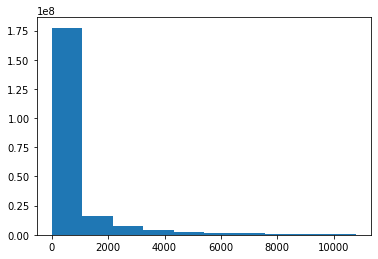

In [38]:
bins=plt.hist(data[(data.sleep_time_modified<=3*60*60)].sleep_time_modified)
plt.show()

In [39]:
bins

(array([1.77421155e+08, 1.62779750e+07, 7.45487800e+06, 4.23407800e+06,
        2.65529500e+06, 1.80275700e+06, 1.29785000e+06, 9.51084000e+05,
        7.16205000e+05, 5.53623000e+05]),
 array([    0.,  1080.,  2160.,  3240.,  4320.,  5400.,  6480.,  7560.,
         8640.,  9720., 10800.]),
 <BarContainer object of 10 artists>)

In [225]:
3240/60

54.0

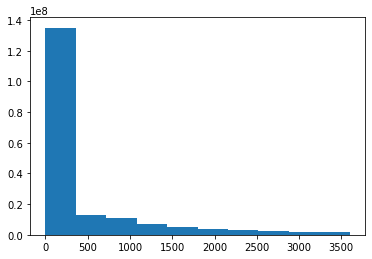

In [43]:
bins=plt.hist(data[(data.sleep_time>=0)&(data.sleep_time<=60*60)].sleep_time)
plt.show()

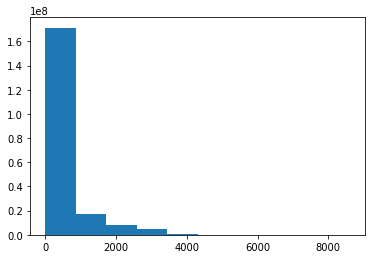

In [41]:
bins=plt.hist(data[(data.sleep_time<=60*60)].sleep_time_modified)
plt.show()

In [42]:
bins

(array([1.71377247e+08, 1.74460110e+07, 8.37818700e+06, 4.92649300e+06,
        6.89646000e+05, 3.00000000e+00, 2.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.00000000e+00]),
 array([   0. ,  860.9, 1721.8, 2582.7, 3443.6, 4304.5, 5165.4, 6026.3,
        6887.2, 7748.1, 8609. ]),
 <BarContainer object of 10 artists>)

In [44]:
bins

(array([1.35080659e+08, 1.32202700e+07, 1.10098710e+07, 7.22456100e+06,
        5.17015600e+06, 3.88320800e+06, 3.03832100e+06, 2.42951600e+06,
        1.98702600e+06, 1.66356100e+06]),
 array([   0.,  360.,  720., 1080., 1440., 1800., 2160., 2520., 2880.,
        3240., 3600.]),
 <BarContainer object of 10 artists>)

In [47]:
1721.8/60

28.696666666666665

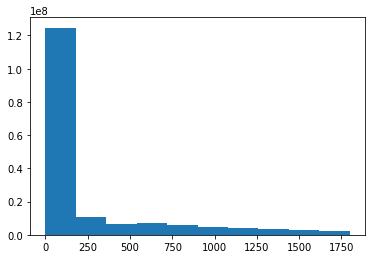

In [50]:
bins=plt.hist(data[(data.sleep_time>=0)&(data.sleep_time<=60*30)].sleep_time)
plt.show()

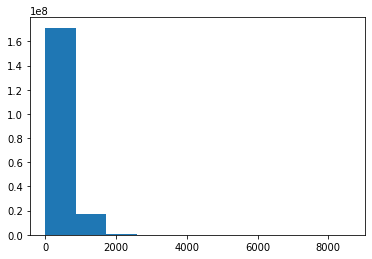

In [51]:
bins=plt.hist(data[(data.sleep_time<=60*30)].sleep_time_modified)
plt.show()

In [52]:
bins

(array([1.71377246e+08, 1.74460110e+07, 1.00469400e+06, 1.20000000e+01,
        3.00000000e+00, 2.00000000e+00, 2.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.00000000e+00]),
 array([   0. ,  860.9, 1721.8, 2582.7, 3443.6, 4304.5, 5165.4, 6026.3,
        6887.2, 7748.1, 8609. ]),
 <BarContainer object of 10 artists>)

In [53]:
2582.7/60

43.044999999999995

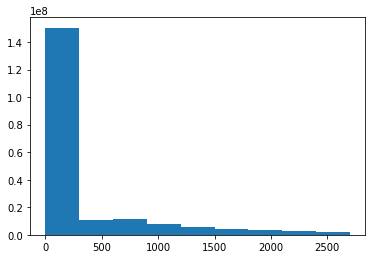

In [56]:
bins=plt.hist(data[(data.sleep_time<=60*45)].sleep_time_modified,bins=[0,60*5,60*10,60*15,60*20,60*25,60*30,60*35,60*40,60*45])
plt.show()

In [57]:
bins

(array([1.50388729e+08, 1.08267590e+07, 1.13687780e+07, 7.54003400e+06,
        5.49813700e+06, 4.19347000e+06, 3.30485100e+06, 2.68090100e+06,
        2.22228400e+06]),
 array([   0,  300,  600,  900, 1200, 1500, 1800, 2100, 2400, 2700]),
 <BarContainer object of 9 artists>)

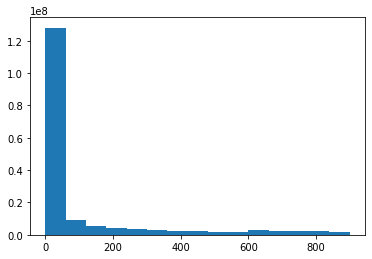

In [59]:
bins=plt.hist(data[(data.sleep_time<=60*15)].sleep_time_modified,bins=[0,60,60*2,60*3,60*4,60*5,60*6,60*7,60*8,60*9,60*10,60*11,60*12,60*13,60*14,60*15])
plt.show()

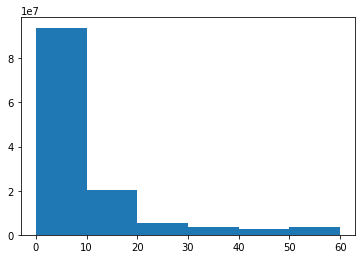

In [60]:
bins=plt.hist(data[(data.sleep_time<=60)].sleep_time_modified,bins=[0,10,20,30,40,50,60])
plt.show()

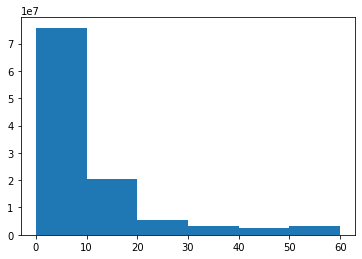

In [64]:
bins=plt.hist(data[(data.sleep_time<=60)&(data.sleep_time>=0)].sleep_time,bins=[0,10,20,30,40,50,60])
plt.show()

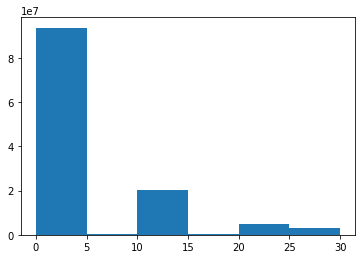

In [61]:
bins=plt.hist(data[(data.sleep_time<=30)].sleep_time_modified,bins=[0,5,10,15,20,25,30])
plt.show()

# Number of sequences vs. sleeptime thressholds.
From the above distributions we see that most sleep times are very low. which mean that we can start the experiement with a relativly low threshold. Start with 1 min, and the avg. sequence length/ number of sequences which are of length 1...

In [45]:
data=pd.read_csv("sorted_coded_data_with_merged_events_10_min.csv")

In [65]:
print(data.sleep_time.quantile(0.9)/60)

43.833333333333336


In [6]:
def count_sequenses(tresshold,df):
    df_temp=df[['user_id','sleep_time']].copy()
    df_temp['sessions']= df_temp.groupby(['user_id']).sleep_time.apply(lambda s: s>tresshold)
    df_temp['sessions'] = df_temp.groupby(['user_id']).sessions.cumsum().astype('int')
    n_sessions=df_temp.groupby(['user_id']).agg({"sessions": "nunique"}).sessions.sum()
    
    return n_sessions

In [5]:
threshold_development=pd.DataFrame({'threshold':[0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45]})

In [6]:
threshold_development['n_sequences']=threshold_development.threshold.apply(lambda l:count_sequenses(l,data))

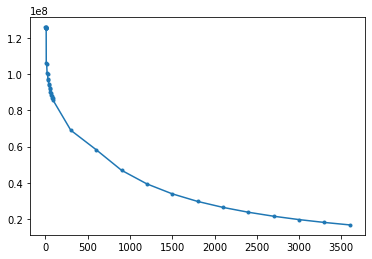

In [21]:
plt.plot(threshold_development['threshold'],threshold_development['n_sequences'],'.-')
plt.show()

The limit of the plot to 45 min was chossen based on 90-quantile which was just under 44 min. We now take a look at the number of sequences of length one for the different threshold values.

In [5]:
def count_sequenses_of_length_1(tresshold,df):
    df_temp=df[['user_id','sleep_time']].copy()
    df_temp['sessions']= df_temp.groupby(['user_id']).sleep_time.apply(lambda s: s>tresshold)
    df_temp['sessions'] = df_temp.groupby(['user_id']).sessions.cumsum().astype('int')
    n_1_sequences=(df_temp.groupby(['user_id','sessions']).agg({"sleep_time": "count"}).sleep_time==1).sum()
    
    return n_1_sequences

In [10]:
threshold_development['number of sequences with only one app']=threshold_development['threshold'].apply(lambda l:count_sequenses_of_length_1(l,data))

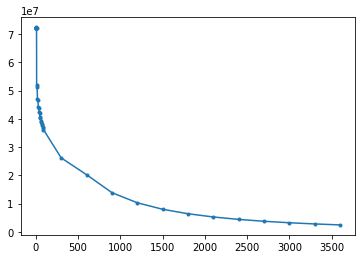

In [22]:
plt.plot(threshold_development['threshold'],threshold_development['number of sequences with only one app'],'.-')
plt.show()

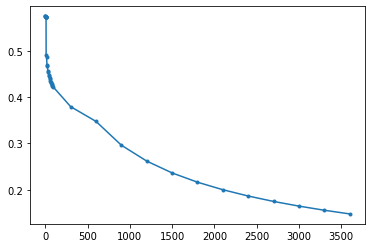

In [23]:
plt.plot(threshold_development['threshold'],threshold_development['number of sequences with only one app']/threshold_development['n_sequences'],'.-')
plt.show()

In [17]:
df=pd.DataFrame({'threshold':[60*50,60*55,60*60]})
df['n_sequences']=df.threshold.apply(lambda l: count_sequenses(l,data))
df['number of sequences with only one app']=df.threshold.apply(lambda l: count_sequenses_of_length_1(l,data))

In [18]:
threshold_development=threshold_development.append(df,ignore_index=True)

We now take a look at the average sequence length for the different thressholds, as to long sequences becomes a challenge when runniing the pattern mining algorithms.

In [25]:
def avg_len_of_sequence(tresshold,df):
    df_temp=df[['user_id','sleep_time']].copy()
    df_temp['sessions']= df_temp.groupby(['user_id']).sleep_time.apply(lambda s: s>tresshold)
    df_temp['sessions'] = df_temp.groupby(['user_id']).sessions.cumsum().astype('int')
    mean_sequence_len=(df_temp.groupby(['user_id','sessions']).agg({"sleep_time": "count"}).sleep_time).mean()
    
    return mean_sequence_len

In [26]:
threshold_development['avg_len_sequence']=threshold_development.threshold.apply(lambda l: avg_len_of_sequence(l,data))

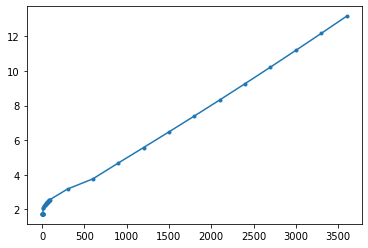

In [29]:
plt.plot(threshold_development['threshold'],threshold_development['avg_len_sequence'],'.-')
plt.show()

In [21]:
60*10

600

In [35]:
def number_of_apps_opened_after_same (tresshold,df):
    df_temp=df[['user_id','sleep_time','app_code']].copy()
    df_temp['sessions']= df_temp.groupby(['user_id']).sleep_time.apply(lambda s: s>tresshold)
    df_temp['sessions'] = df_temp.groupby(['user_id']).sessions.cumsum().astype('int')
    df_temp['previous_app_code']=df_temp.groupby(['user_id','sessions']).app_code.shift(1) 
    n_app=df_temp[df_temp['previous_app_code']==df_temp['app_code']].shape[0]

    return n_app

In [36]:
threshold_development['number_of_apps_opened_after_same']=threshold_development.threshold.apply(lambda l: number_of_apps_opened_after_same(l,data))

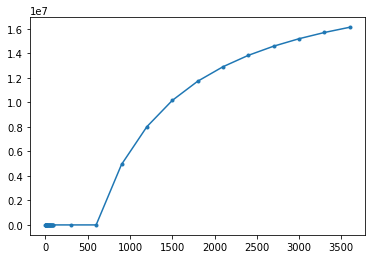

In [8]:
plt.plot(threshold_development['threshold'],threshold_development['number_of_apps_opened_after_same'],'.-')
plt.show()

In [37]:
threshold_development

,threshold,n_sequences,number of sequences with only one app,avg_len_sequence,number_of_apps_opened_after_same
0,0,125933226,72417853,1.742870,34
1,1,125832950,72305700,1.744259,34
2,2,125804540,72275444,1.744653,34
3,3,125773996,72242644,1.745077,34
4,4,125743436,72209409,1.745501,34
5,5,125713338,72177798,1.745919,34
6,6,125684951,72148294,1.746313,34
7,7,125657402,72119855,1.746696,34
8,8,125630088,72091487,1.747076,34
9,9,125589736,72047162,1.747637,34


In [39]:
threshold_development.to_csv("threshold.csv",index=False)

In [4]:
threshold_development=pd.read_csv("threshold.csv")

In [9]:
data.sleep_time.quantile(0.90)

2630.0

In [26]:
data.sleep_time.quantile(0.95)

5644.0

Maybe test number times apps are used in a row, after a threshold has been selected? this might indicate whether the choise of merge threshold (10min) has been selected appropiatly. And maybe the potential effect on the number of only ones.

# Recalculating sleep time
So fare we have been working with a sleep time which only take in to account the time period, or lack of same from the previous opened app is closed to the current one is opened. This entail a couple of problems. The first one being as we saw eariler that in situations where the app is after the next one is opened, a negative sleep time is created. Secondly this method fail to recognise cases where two non overlaping app usages might be fully encapusualed by another app. An example of such a situation can be seen here:

app A open, app B open, app B close, app C open, app C close, app A close.

Here the sleep time for C would correspond to the difference between when B is closed and C is opend, which mean that an actualy sleep time would be mesured. However this does not represent reality. since A is still being used in the sleep time for C should be 0.

In this section the sleep time is therefore recalculated to represent the more realistic measure of time with inactivity before the app is opened.

In [62]:
data=pd.read_csv("sorted_coded_data_with_merged_events_10_min.csv")

In [63]:
data

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
0,com.facebook.katana,0,0,441,441,19968,0.0,0.0,NaN
1,com.android.chrome,0,441,1012,571,7649,0.0,0.0,19968.0
2,com.google.android.apps.photos,0,1012,1032,20,23916,0.0,0.0,7649.0
3,com.facebook.katana,0,1042,1502,460,19968,10.0,10.0,23916.0
4,com.whatsapp,0,1512,1572,60,53003,10.0,10.0,19968.0
...,...,...,...,...,...,...,...,...,...
219485293,com.google.android.googlequicksearchbox,9999,29207214,29207244,30,23949,185.0,185.0,19968.0
219485294,com.android.chrome,9999,29207244,29207284,40,7649,0.0,0.0,23949.0
219485295,com.google.android.apps.docs,9999,29207284,29207294,10,23875,0.0,0.0,7649.0
219485296,com.microsoft.office.outlook,9999,29213184,29213213,29,33357,5890.0,5890.0,23875.0


In [64]:
data2=data.copy()

In [65]:
data2

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code
0,com.facebook.katana,0,0,441,441,19968,0.0,0.0,NaN
1,com.android.chrome,0,441,1012,571,7649,0.0,0.0,19968.0
2,com.google.android.apps.photos,0,1012,1032,20,23916,0.0,0.0,7649.0
3,com.facebook.katana,0,1042,1502,460,19968,10.0,10.0,23916.0
4,com.whatsapp,0,1512,1572,60,53003,10.0,10.0,19968.0
...,...,...,...,...,...,...,...,...,...
219485293,com.google.android.googlequicksearchbox,9999,29207214,29207244,30,23949,185.0,185.0,19968.0
219485294,com.android.chrome,9999,29207244,29207284,40,7649,0.0,0.0,23949.0
219485295,com.google.android.apps.docs,9999,29207284,29207294,10,23875,0.0,0.0,7649.0
219485296,com.microsoft.office.outlook,9999,29213184,29213213,29,33357,5890.0,5890.0,23875.0


The following part of the solution is inspired by the following. 
https://stackoverflow.com/questions/57804145/combining-rows-with-overlapping-time-periods-in-a-pandas-dataframe (visited 29.10.2021)

In [6]:
def join_times(x):
    startdf = pd.DataFrame({'time':x['start_time'], 'what':1})
    enddf = pd.DataFrame({'time':x['end_time'], 'what':-1})
    mergdf = pd.concat([startdf, enddf]).sort_values(['time','what'])
    mergdf['running'] = mergdf['what'].cumsum()
    mergdf['new_sequence'] = mergdf['running'].eq(1) & mergdf['what'].eq(1)
    mergdf['sequence_number'] = mergdf['new_sequence'].cumsum()
    x['sequence_number'] = mergdf['sequence_number'].loc[mergdf['what'].eq(1)]
    return x['sequence_number']

In [69]:
data2['sequence_number']=data2.groupby('user_id').apply(join_times).reset_index().drop(['user_id','level_1'], axis=1).values

In [70]:
data2=pd.merge(data2,data2.groupby(['user_id','sequence_number']).agg({'start_time':'min','end_time':'max'}).reset_index().rename(columns={'end_time':'sequence_end_time','start_time':'sequence_Start_time'}),how='left', on=['user_id','sequence_number'])

In [75]:
data2.head(20)

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,sequence_number,sequence_Start_time,sequence_end_time
0,com.facebook.katana,0,0,441,441,19968,0.0,0.0,NaN,1,0,441
1,com.android.chrome,0,441,1012,571,7649,0.0,0.0,19968.0,2,441,1012
2,com.google.android.apps.photos,0,1012,1032,20,23916,0.0,0.0,7649.0,3,1012,1032
3,com.facebook.katana,0,1042,1502,460,19968,10.0,10.0,23916.0,4,1042,1502
4,com.whatsapp,0,1512,1572,60,53003,10.0,10.0,19968.0,5,1512,1572
5,com.google.android.youtube,0,1582,1712,130,23967,10.0,10.0,53003.0,6,1582,1712
6,com.whatsapp,0,1712,2221,509,53003,0.0,0.0,23967.0,7,1712,2221
7,com.whatsapp,0,3449,3579,130,53003,1228.0,1228.0,53003.0,8,3449,3579
8,com.facebook.katana,0,3579,3669,90,19968,0.0,0.0,53003.0,9,3579,3669
9,com.whatsapp,0,3669,3926,257,53003,0.0,0.0,19968.0,10,3669,3926


In [76]:
data2['sleep_time_updated']=data2.start_time-data2.sequence_end_time.shift(1,fill_value=0)

In [79]:
data2[data2['sleep_time_updated']<0]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,sequence_number,sequence_Start_time,sequence_end_time,sleep_time_updated
10,bg.abv.andro.emailapp,0,3689,3699,10,2340,-237.0,0.0,53003.0,10,3669,3926,-237
18,com.facebook.katana,0,28836,29777,941,19968,-70.0,0.0,23926.0,17,28766,29777,-941
54,com.google.android.apps.translate,0,53793,53803,10,23926,-210.0,0.0,7649.0,52,53753,54003,-210
98,com.sonyericsson.video,0,173946,174206,260,45286,-30.0,0.0,45260.0,95,173926,174226,-280
99,com.sonyericsson.album,0,174036,174226,190,45260,-170.0,0.0,45286.0,95,173926,174226,-190
...,...,...,...,...,...,...,...,...,...,...,...,...,...
219485238,com.sonyericsson.music,9999,29133717,29133737,20,45284,-287.0,0.0,53003.0,13415,29133587,29134004,-287
219485253,com.google.android.googlequicksearchbox,9999,29156883,29156933,50,23949,-111.0,0.0,44880.0,13429,29156853,29156994,-111
219485259,com.sonyericsson.album,9999,29158879,29158889,10,45260,-20.0,0.0,45264.0,13434,29158868,29158899,-20
219485268,com.whatsapp,9999,29162905,29163500,595,53003,-50.0,0.0,19968.0,13442,29162675,29163500,-595


In [87]:
data2.loc[data2[data2['sleep_time_updated']<0].index,'sleep_time_updated']=0

In [88]:
data2[data2['sleep_time_updated']<0]

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,sequence_number,sequence_Start_time,sequence_end_time,sleep_time_updated


In [90]:
data2.to_csv('sorted_merged_sleep_time_recalculated.csv',index=False)

In [92]:
data2.head(20)

,package_name,user_id,start_time,end_time,time_spend,app_code,sleep_time,sleep_time_modified,previous_app_code,sequence_number,sequence_Start_time,sequence_end_time,sleep_time_updated
0,com.facebook.katana,0,0,441,441,19968,0.0,0.0,NaN,1,0,441,0
1,com.android.chrome,0,441,1012,571,7649,0.0,0.0,19968.0,2,441,1012,0
2,com.google.android.apps.photos,0,1012,1032,20,23916,0.0,0.0,7649.0,3,1012,1032,0
3,com.facebook.katana,0,1042,1502,460,19968,10.0,10.0,23916.0,4,1042,1502,10
4,com.whatsapp,0,1512,1572,60,53003,10.0,10.0,19968.0,5,1512,1572,10
5,com.google.android.youtube,0,1582,1712,130,23967,10.0,10.0,53003.0,6,1582,1712,10
6,com.whatsapp,0,1712,2221,509,53003,0.0,0.0,23967.0,7,1712,2221,0
7,com.whatsapp,0,3449,3579,130,53003,1228.0,1228.0,53003.0,8,3449,3579,1228
8,com.facebook.katana,0,3579,3669,90,19968,0.0,0.0,53003.0,9,3579,3669,0
9,com.whatsapp,0,3669,3926,257,53003,0.0,0.0,19968.0,10,3669,3926,0


# Continued overall perspective. 
With the redefined sleep times, the exploration from the overall perspective is continued.

In [2]:
data=pd.read_csv('sorted_merged_sleep_time_recalculated.csv')

In [5]:
data=data.drop(['sleep_time','sleep_time_modified','time_spend'],axis=1)

## sleep time distribution.
The first step is to take a look at the distribution of the updated sleep time.

In [ ]:
print("Number of observerations with 0 sleep time associated: ", data2[data2.sleep_time_updated==0].shape[0])
print("Procent of observerations with 0 sleep time associated: ", data2[data2.sleep_time_updated==0].shape[0]/data2.shape[0]*100)

The time features are updated from seconds to minutes.

In [6]:
data['start_time']=data.start_time/60

In [7]:
data['end_time']=data.end_time/60

In [8]:
data['sleep_time_updated']=data.sleep_time_updated/60

Now we take a look at the overall destribution.

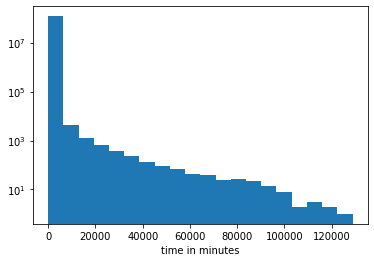

In [9]:
plt.hist(data[data.sleep_time_updated>0].sleep_time_updated,bins=20)
plt.xlabel('time in minutes')
plt.yscale('log')

Again we see that most of the sleep time is at the early part of the interval\
We now take at look at the sleep time less than 8 hours, as this is considered an indication that you are sleeping, and there should be there.

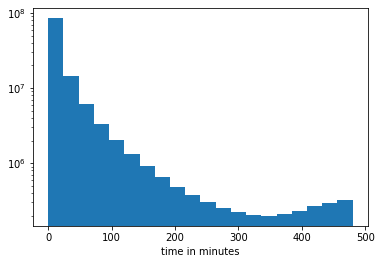

In [10]:
plt.hist(data[(data.sleep_time_updated>0)&(data.sleep_time_updated<8*60)].sleep_time_updated,bins=20)
plt.xlabel('time in minutes')
plt.yscale('log')

In [11]:
print("median: ",data[(data.sleep_time_updated>0)&(data.sleep_time_updated<8*60)].sleep_time_updated.median())
print("95-quantile: ",data[(data.sleep_time_updated>0)&(data.sleep_time_updated<8*60)].sleep_time_updated.quantile(q=0.90))

median:  7.65
95-quantile:  71.41666666666667


Based on the quantiles the threeshold for sessions are set to 8 min.

In [12]:
data['new_session'] = data.groupby(['user_id']).sleep_time_updated.apply(lambda s: s>8)

In [13]:
data['session'] = data.groupby(['user_id']).new_session.cumsum().astype('int')

In [14]:
data.to_csv("sorted_merged_overlap_removed_with_sessions.csv",index=False)

# Distribution of sequece lengths for chosen threshold
In this section the distribution of the number of apps (sequence length) in each session.

In [19]:
sequence_lengths=data.groupby(['user_id','session']).app_code.count().values

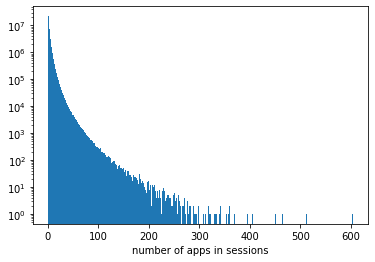

In [30]:
plt.hist(sequence_lengths,bins=range(min(sequence_lengths), max(sequence_lengths) + 1, 1))
plt.yscale('log')
plt.xlabel('number of apps in sessions')
plt.show()

It is clear from the distribution plot that while most of the sessions are short, the chossen treshold also has created some very long sessions. An app usage sequence of for instance 600 apps, does for instance not seem realistic. Based on the below quantile it is however indicated that only very few observations falls within this category.

In [50]:
print("median session lengths: ",np.median(sequence_lengths))
print("99-quantile of session lengths: ",np.quantile(sequence_lengths,q=0.99))

median session lengths:  2.0
99-quantile of session lengths:  23.0


We now take a look at how the sequence lengths are distributed, within the 99-quantile.

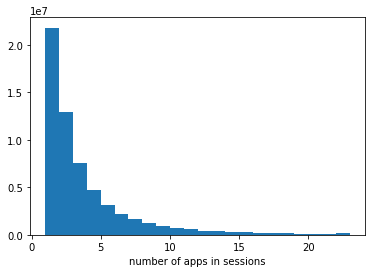

In [40]:
plt.hist(sequence_lengths[sequence_lengths<=np.quantile(sequence_lengths,q=0.99)],bins=range(1, 23 + 1, 1))
plt.xlabel('number of apps in sessions')
plt.show()

As expected it becomes even more evident that the majority of sessions are short, and the most common length is 1. However to get a more full understanding we take a look at how large a part of the sessions only contain one app.

In [49]:
print("procent of sessions with length one: ",sequence_lengths[sequence_lengths==1].size/sequence_lengths.size*100)
print("number of sessions: ",sequence_lengths.size)

procent of sessions with length one:  36.10294627292334
number of sessions:  60393794


While the distribution look reasonable, and it appear realistic that a large number of the sessions only contain one app usage, there is still the unrealistic number for sequence lengths which appear unrealistic. When comparing with what have been done in other projects concerned with app usage, similar definition of use session have been applied. However for comparison there thress hold for sleep time defining the start of a new seesion is much low, either something opened right after, or only 30 seconds. It is therefore worth considering if the 8 min. thresshold is to high and allow for unrealistic patterns. While a potential lower thresshold will result in more session of length one, more relevant result for our aim of intrest might be optained by only applying the algorithm to sessions of length more than two. However revevaluation the thresshold, would also mean that we should reevaluate the limit of the same observations should be combined. In regard to this is it worth considering if the combination should happen after an over all thresshold for defining sesions have been determined, and there after simply combining all observations which are right after each other within the same session.

# Combining repeating apps after defining the sessions.

In [2]:
data=pd.read_csv('sorted_coded_data.csv')

Again the sleep time must be recalculated to take into acount overlap in use of apps.

Remember to run the function definition of join_times.

In [8]:
data['sequence_number']=data.groupby('user_id').apply(join_times).reset_index().drop(['user_id','level_1'], axis=1).values
data=pd.merge(data,data.groupby(['user_id','sequence_number']).agg({'start_time':'min','end_time':'max'}).reset_index().rename(columns={'end_time':'sequence_end_time','start_time':'sequence_Start_time'}),how='left', on=['user_id','sequence_number'])
data['sleep_time']=data.start_time-data.sequence_end_time.shift(1,fill_value=0)
data.loc[data[data['sleep_time']<0].index,'sleep_time']=0

In [13]:
print("Number of observations: ",data.shape[0])

Number of observations:  254450422


## Sleep time distibution
Out of curiosity we take a look at the sleep time distribution, which should varry slightly since no observations have merged at this point

In [23]:
print("Procent of observation with no (zero) sleep time associated: ",data[data.sleep_time==0].shape[0]/data.shape[0]*100)
print("Longest sleep time: ",data.sleep_time.max()/60/60/24)

Procent of observation with no (zero) sleep time associated:  40.567149462224116
Longest sleep time:  89.44747685185185


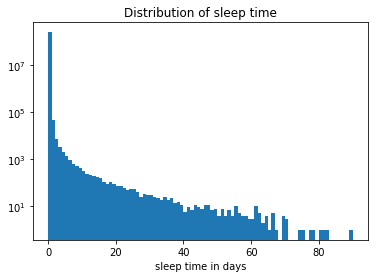

In [27]:
plt.hist(data.sleep_time/60/60/24,bins=range(0, 90 + 1, 1))
plt.xlabel('sleep time in days')
plt.yscale('log')
plt.title("Distribution of sleep time")
plt.show()

Again we take a look at the distrbution of sleep times less than 8 hours.

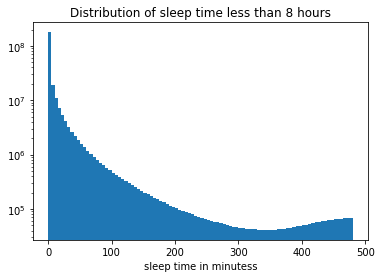

In [44]:
plt.hist(data[data.sleep_time<8*60*60].sleep_time/60,bins=range(0, 480 + 1, 5))
plt.xlabel('sleep time in minutess')
plt.yscale('log')
plt.title("Distribution of sleep time less than 8 hours")
plt.show()

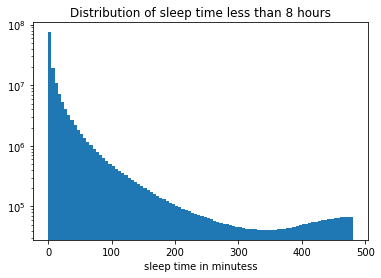

In [46]:
plt.hist(data[(data.sleep_time<8*60*60)&(data.sleep_time>0)].sleep_time/60,bins=range(0, 480 + 1, 5))
plt.xlabel('sleep time in minutess')
plt.yscale('log')
plt.title("Distribution of sleep time less than 8 hours")
plt.show()

In [48]:
print("media of sleep times non-zero sleep times less than 8 hours: ",data[(data.sleep_time<8*60*60) & (data.sleep_time>0)].sleep_time.median()/60,"min")

media of sleep times non-zero sleep times less than 8 hours:  4.883333333333334 min


In [59]:
print("median of sleep times less than 8 hours: ",data[data.sleep_time<8*60*60].sleep_time.median(),"sec")

median of sleep times less than 8 hours:  20.0 sec


With a sleep time of 20 sec, which is much lower than before, and a lot closer to what we saw for similar projects, this is used as the threshold for defining session.

## Defining sessions.

In [61]:
data['new_session'] = data.groupby(['user_id']).sleep_time.apply(lambda s: s>20)
data['session'] = data.groupby(['user_id']).new_session.cumsum().astype('int')

In [72]:
print("Number sessions: ",data.groupby(['user_id']).session.nunique().sum())

Number sessions:  125704179


### Distribution of session lengths

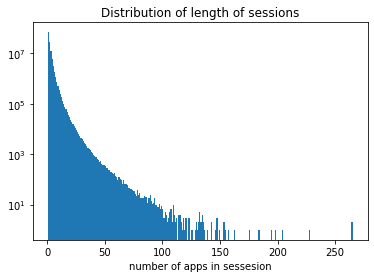

In [89]:
plt.hist(data.groupby(['user_id','session']).size(),bins=range(1,data.groupby(['user_id','session']).size().max()+1,1))
plt.xlabel('number of apps in sessesion')
plt.yscale('log')
plt.title("Distribution of length of sessions")
plt.show()

In [91]:
print("procent of session with only one app: ",(data.groupby(['user_id','session']).size()==1).sum()/data.groupby(['user_id']).session.nunique().sum()*100)

procent of session with only one app:  55.033392326598786


In [92]:
print("75-quantile of session lengths: ",data.groupby(['user_id','session']).size().quantile(q=0.75))

75-quantile of session lengths:  2.0


It is clear to see that with the new time restriction a lot of the sequences are very short. This number is expected to increase further as same apps are merged in the next section

In [93]:
data.to_csv("sorted_coded_session_20s.csv",index=False)

## Combining observations of where the same app is used 

In [2]:
data=pd.read_csv("sorted_coded_session_20s.csv")

In [3]:
data["previous_app_code"]=data.groupby(["user_id","session"]).app_code.shift(1)

In [5]:
print("Procent of apps opened right after the same app, in the ",data[data.app_code==data.previous_app_code].shape[0]/data.shape[0]*100)

Procent of apps opened right after the same app, in the  1.5072358575219813


In [6]:
data2=data.copy()

In [10]:
data2=data2[(data2.previous_app_code==data2.app_code) | (data2.app_code==data2.groupby(['user_id','session']).app_code.shift(-1))]

In [11]:
data2['new_event'] = data2.previous_app_code!=data2.app_code

In [15]:
data2['event'] = data2.groupby(['user_id','session']).new_event.cumsum().astype('int')

In [21]:
data2_grouped = data2.groupby(['user_id', 'session','event']).agg({'end_time':'max'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'end_time':'event_end_time'})

data3 = pd.merge(data2, data2_grouped, how='left', on=['user_id', 'session','event'])

data3 = data3[data3['end_time'] == data3['event_end_time']]

#because in the same event more apps can be closed at once.
data3=data3.drop_duplicates(subset=['user_id', 'session','event'], keep='last')

In [24]:
max_index=data2.iloc[data3.index].index

In [27]:
data2_grouped = data2.groupby(['user_id', 'session','event']).agg({'start_time':'min'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'start_time':'event_start_time'})

data3 = pd.merge(data2, data2_grouped, how='left', on=['user_id', 'session','event'])

data3 = data3[data3['start_time'] == data3['event_start_time']]

#because in the same event more apps can be opened at once.
data3=data3.drop_duplicates(subset=['user_id', 'session','event'], keep='last')

In [28]:
min_index=data2.iloc[data3.index].index

In [29]:
print("number of combined events: ",data2.groupby(['user_id','session']).agg({"event": "nunique"}).event.sum())
print("number of found min indices: ",len(min_index))
print("number of found max indices: ",len(max_index))

number of combined events:  3212643
number of found min indices:  3212643
number of found max indices:  3212643


In [30]:
data3=data.copy()

In [31]:
data3.loc[min_index,"end_time"]=data3.loc[max_index].set_index(min_index).end_time

In [40]:
data3=data3.drop(set(data2.index)-set(min_index))

In [41]:
len(data.index)-(len(data2.index)-len(min_index))==len(data3.index)

True

In [43]:
data3['time_spend']=data3['end_time']-data3['start_time']

In [46]:
data3=data3.drop('previous_app_code',axis=1)

In [48]:
data3['sleep_time']=data3.start_time-data3.sequence_end_time.shift(1,fill_value=0)
data3.loc[data3[data3['sleep_time']<0].index,'sleep_time']=0

In [54]:
data3=data3.reset_index(drop=True)

In [52]:
print("number of observatiosn before merge: ",data.shape[0])
print("number of observatiosn after merge: ",data3.shape[0])

number of observatiosn before merge:  254450422
number of observatiosn after merge:  250615254


In [55]:
data3.to_csv("sorted_coded_session_20s_merged.csv",index=False)

In [2]:
data3=pd.read_csv("sorted_coded_session_20s_merged.csv")

### distibution of sequence lengths after merge

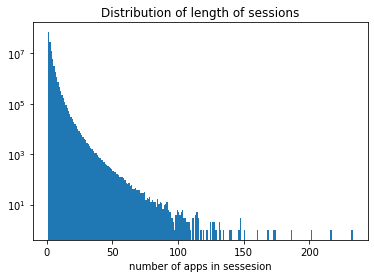

In [57]:
plt.hist(data3.groupby(['user_id','session']).size(),bins=range(1,data3.groupby(['user_id','session']).size().max()+1,1))
plt.xlabel('number of apps in sessesion')
plt.yscale('log')
plt.title("Distribution of length of sessions")
plt.show()

In [77]:
print("procent of sessions with length one: ",((data3.groupby(['user_id','session']).size())==1).sum()/data3.groupby(['user_id','session']).size().shape[0]*100)
print("number of sessions: ",data3.groupby(['user_id','session']).size().shape[0])

procent of sessions with length one:  55.12311885828394
number of sessions:  125704179


We see that this is on a similar level as before the merge.

### Filtering out the sessions with only one app.

In [3]:
data4=(data3.groupby(['user_id', 'session']).agg({'app_code':'size'})).reset_index().rename(columns={'app_code':'session_length'})

In [4]:
data5=pd.merge(data3, data4, how='left', on=['user_id','session'])

In [5]:
data5=data5[data5.session_length>1]

In [6]:
print("procent of sessions with length one: ",((data5.groupby(['user_id','session']).size())==1).sum()/data5.groupby(['user_id','session']).size().shape[0]*100)
print("number of sessions: ",data5.groupby(['user_id','session']).size().shape[0])

procent of sessions with length one:  0.0
number of sessions:  56412115


### Testing 

In [ ]:
input_string=data5.groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [ ]:
f = open(os.path.join(os.getcwd(), '20sec_sessions.txt'), 'w')
dfAsString = input_string.to_string(header=False, index=False)
dfAsString=re.sub(r'\\n -1','\n',dfAsString)
dfAsString=re.sub(r'\n\s+','\n',dfAsString)
f.write(re.sub(r'-2\n-2+','-2\n',dfAsString.lstrip()))
f.close()

# Experimenting with lower threshold.